# Multislice Least Squares (1D x–z)

In [11]:
# Imports
import os, sys, numpy as np, matplotlib.pyplot as plt
proj_root = "/home/dnz75396/thick_ptycho"
sys.path.insert(0, proj_root)

from thick_ptycho.sample_space.sample_space import SampleSpace
from thick_ptycho.forward_model.multislice import MultiSliceForwardModel
from thick_ptycho.utils.visualisations import Visualisation

In [12]:
bc_type = "impedance"     # Boundary condition type 
probe_type = "airy_disk"                 # Disk probe

# Constants
wavelength = 0.635e-6   # meters
k0 = 2 * np.pi / wavelength  # wavenumber [1/m]
print(f"{k0=:.3e}")
# Background refractive index
nb = 1.0  # soft tissue approx. in vacuum

# Refractive index perturbation for soft tissue
delta = 0.01
beta = 0.001
refractive_index_perturbation = - delta - beta*1j 

# Spatial dimensions
xlims = [0.0, 150e-6]   # meters (sample width)
zlims = [0.0, 75e-6]   # meters (sample thickness)
continuous_dimensions = [xlims, zlims]


# Choose nz to satisfy paraxial resolution:
# Use approx. λ/4 axial resolution → ∆z ≈ λ / 4 ≈ 0.125 μm → nz = (z_range / ∆z)
z_range = zlims[1] - zlims[0]
dz = wavelength *8
nz = int(z_range / dz)  
print(f"{nz=}")

# z_range = zlims[1] - zlims[0]
# dz = wavelength * 32
# nz = int(z_range / dz)  
# print(f"{nz=}")

# Discrete space parameters
probe_dimensions = [40]             # Discrete Probe dimensions
probe_diameter = int(0.8 * min(probe_dimensions))
scan_points = 124  # image planes
step_size = 3   

probe_angles_list = [0.0]               # Step size in pixels
probe_focus =  -0.000005 # focal length [m]

# Discrete space limits (pixels)
min_nx = int(scan_points * step_size + probe_dimensions[0])

# Number of pixels in x directions
nx = min_nx*2
discrete_dimensions = [
    nx,
    nz
    ]   
print(f"{discrete_dimensions=}")

k0=9.895e+06
nz=14
discrete_dimensions=[824, 14]


In [13]:
sample_space = SampleSpace(
    continuous_dimensions,   # meters
    discrete_dimensions,     # pixels (nx, nz)
    probe_dimensions,        # detector/probe window (pixels)
    scan_points,             # number of scan positions
    step_size,
    bc_type,                 # impedance / dirichlet / neumann
    probe_type,
    k0,                      # wavenumber [1/m]
    probe_diameter=probe_diameter,
    probe_focus=probe_focus,        
    n_medium=nb,
)

sample_space.summarize_sample_space()
visualisation = Visualisation(sample_space)

2025-10-16 17:23:23,925 - INFO - === Scan Summary (Continuous) ===
2025-10-16 17:23:23,926 - INFO -   Sample space (x-range): 1.500e-04 m
2025-10-16 17:23:23,927 - INFO -   Sample space (z-range): 7.500e-05 m
2025-10-16 17:23:23,927 - INFO -   Probe diameter:         5.832e-06 m
2025-10-16 17:23:23,928 - INFO -   Number of scan points:  124
2025-10-16 17:23:23,929 - INFO -   Steps in z:             14
2025-10-16 17:23:23,930 - INFO -   Detector Pixels:        824
2025-10-16 17:23:23,931 - INFO -   Max Overlap:            5.286e-06 m
2025-10-16 17:23:23,931 - INFO -   Percentage Overlap:     90.62%



In [14]:
gaussian_blur = 0.5

# Add 6 spheres of varying diameters and positions
common_side_length = 0.05*xlims[1]  # μm diameter
common_depth = 0.05*zlims[1]  # μm depth

# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,  # μm diameter
#                         centre=(0.5*xlims[1], 0.2*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(0.4*xlims[1], 0.2*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(0.65*xlims[1], 0.6*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(0.4*xlims[1], 0.7*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(0.55*xlims[1], 0.45*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(0.6*xlims[1], 0.3*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)

sample_space.generate_sample_space()

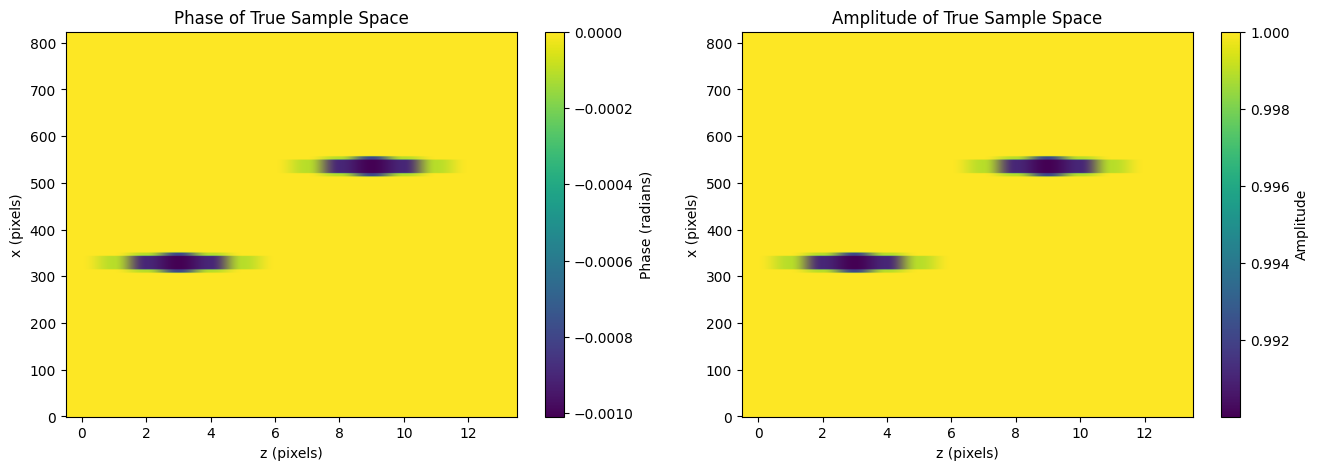

In [15]:
# Plot the true sample space
title = "True Sample Space"
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

true_phase = np.angle(sample_space.n_true)
true_amplitude = np.abs(sample_space.n_true)
vmin_phase = np.min(true_phase)
vmax_phase = np.max(true_phase)
vmin_amp = np.min(true_amplitude)
vmax_amp = np.max(true_amplitude)

# Get min and max values from the true sample space for color scaling
axs[0].set_title("Phase of True Sample Space")
im0 = axs[0].imshow(true_phase, origin='lower', aspect='auto', cmap='viridis', vmin=vmin_phase, vmax=vmax_phase)
axs[0].set_xlabel('z (pixels)')
axs[0].set_ylabel('x (pixels)')
fig.colorbar(im0, ax=axs[0], label='Phase (radians)')

# Amplitude subplot
axs[1].set_title("Amplitude of True Sample Space")
im1 = axs[1].imshow(true_amplitude, origin='lower', aspect='auto', cmap='viridis', vmin=vmin_amp, vmax=vmax_amp)
axs[1].set_xlabel('z (pixels)')
axs[1].set_ylabel('x (pixels)')
fig.colorbar(im1, ax=axs[1], label='Amplitude')

dx=0.0000, dz=0.0000


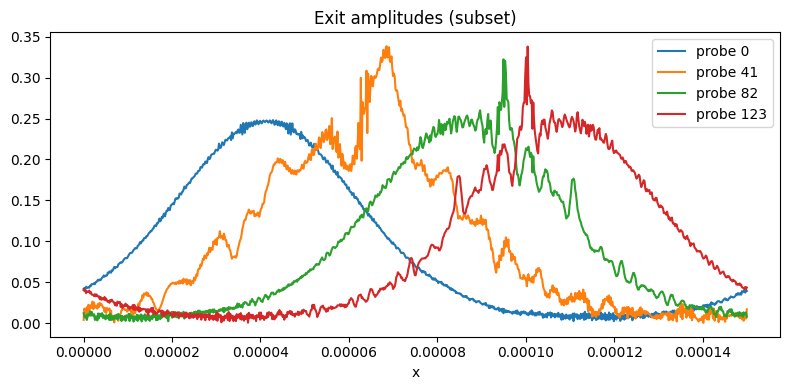

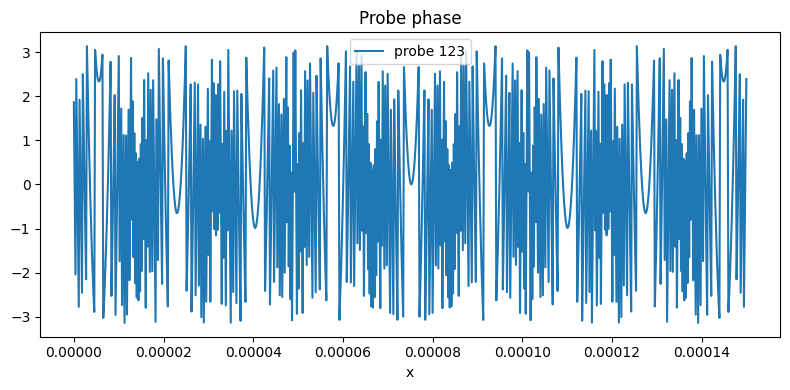

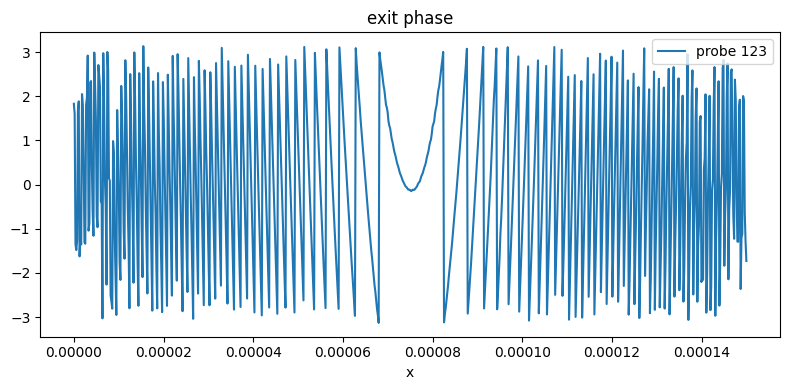

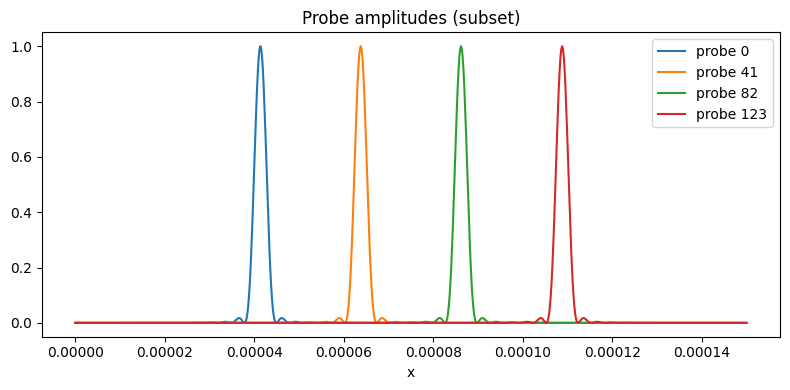

(<Figure size 1200x500 with 4 Axes>,
 (<Axes: title={'center': 'Phase'}, xlabel='Z', ylabel='X'>,
  <Axes: title={'center': 'Amplitude'}, xlabel='Z', ylabel='X'>))

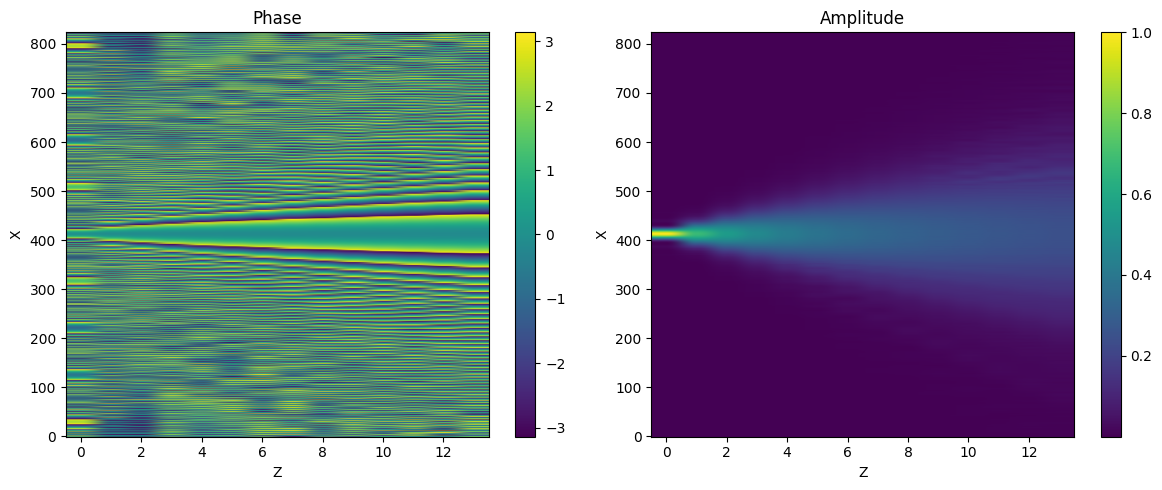

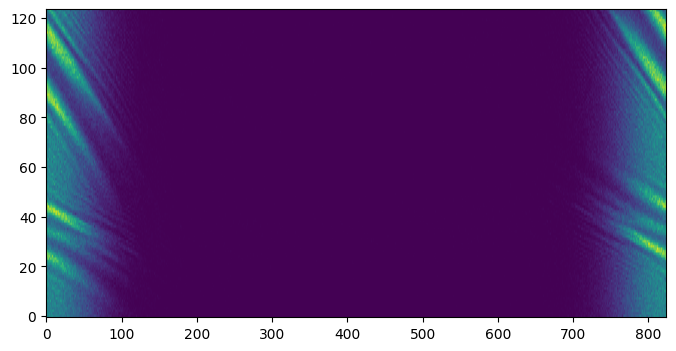

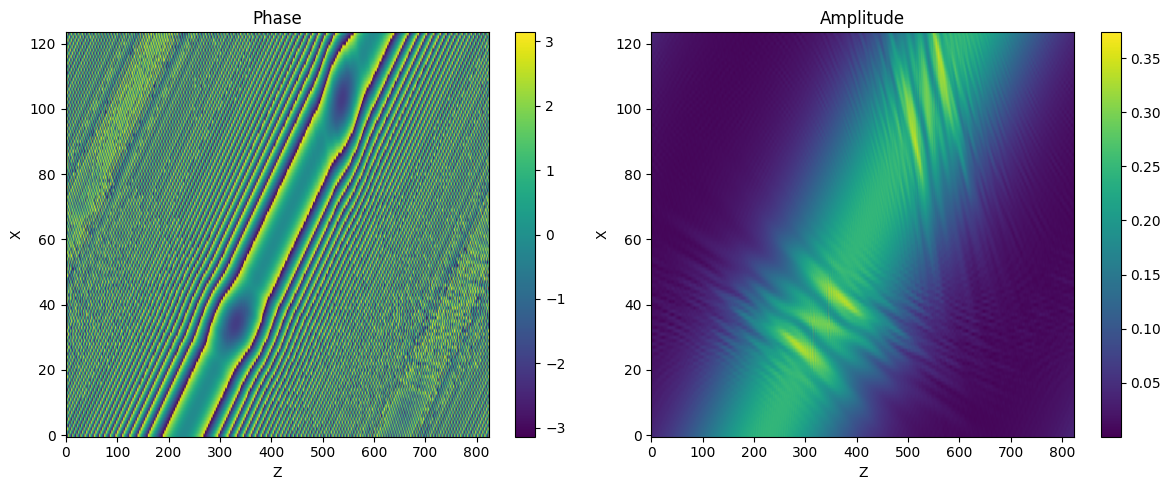

In [16]:
# Instantiate updated multislice forward model (moving probes)
ms = MultiSliceForwardModel(sample_space)

field_true = ms.forward()

exit_stack = field_true[:, :, -1]
probe_stack = ms.probes
exit_stack_amp = np.abs(exit_stack)
probe_stack_amp = np.abs(probe_stack)
exit_stack_phase = visualisation.phase(exit_stack)

probe_stack_phase = visualisation.phase(probe_stack)

# If you also need continuity across probe index, uncomment:
# probe_stack_phase = np.unwrap(probe_stack_phase, axis=0)
noise_level = 0.02
data = np.zeros((scan_points,nx))
for i in range(scan_points):
    data[i, :] = np.random.poisson(np.square(np.abs(np.fft.fft(exit_stack[i, :]))))

x = sample_space.x if sample_space.bc_type != "dirichlet" else sample_space.x[1:-1]
z = sample_space.z
X, Z = np.meshgrid(x, z, indexing='ij')
dx, dz = sample_space.dx, sample_space.dz
print(f"dx={dx:.4f}, dz={dz:.4f}")


plt.figure(figsize=(8,4))
probe_indices = np.linspace(0, sample_space.num_probes-1, min(4, sample_space.num_probes), dtype=int)
for p in probe_indices:
    plt.plot(x, exit_stack_amp[p], label=f'probe {p}')
plt.title("Exit amplitudes (subset)")
plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(x, probe_stack_phase[int(sample_space.num_probes/2)], label=f'probe {p}')
plt.title("Probe phase")
plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(x, exit_stack_phase[int(sample_space.num_probes/2)], label=f'probe {p}')
plt.title("exit phase")
plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
for p in probe_indices:
    plt.plot(x, probe_stack_amp[p], label=f'probe {p}')
plt.title("Probe amplitudes (subset)")
plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()


visualisation.plot_auto(field_true[int(sample_space.num_probes/2),:,:], view="phase_amp", layout="single")

plt.figure(figsize=(8,4))
plt.imshow(data, aspect='auto', origin='lower')


visualisation.plot_auto(exit_stack, view="phase_amp", layout="single")

In [17]:
# from thick_ptycho.reconstruction.least_squares import LeastSquaresSolver
# # Solve full system all-at-once or iteratively
# least_squares = LeastSquaresSolver(sample_space,full_system_solver=False,probe_angles_list=probe_angles_list)

In [18]:
# least_squares.true_exit_waves - exit_stack
# plt.figure(figsize=(8,4))
# visualisation.plot_auto(least_squares.true_exit_waves - exit_stack, view="phase_amp", layout="single")

[Iter 001]  Mean Loss = 4.079e-01
[Iter 002]  Mean Loss = 3.639e-01
[Iter 003]  Mean Loss = 3.433e-01
[Iter 004]  Mean Loss = 3.305e-01
[Iter 005]  Mean Loss = 3.214e-01
[Iter 006]  Mean Loss = 3.144e-01
[Iter 007]  Mean Loss = 3.090e-01
[Iter 008]  Mean Loss = 3.045e-01
[Iter 009]  Mean Loss = 3.007e-01
[Iter 010]  Mean Loss = 2.975e-01


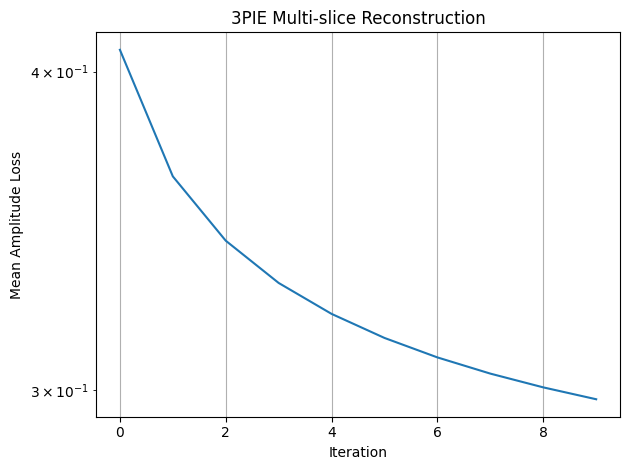

In [19]:
n_est, loss_history=ms.reconstruct(data, epochs=10, alpha_obj=1e-3, verbose=True)

plt.figure()
plt.semilogy(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Mean Amplitude Loss")
plt.title("3PIE Multi-slice Reconstruction")
plt.grid(True)
plt.tight_layout()
plt.show()

(<Figure size 1200x500 with 4 Axes>,
 (<Axes: title={'center': 'Phase'}, xlabel='Z', ylabel='X'>,
  <Axes: title={'center': 'Amplitude'}, xlabel='Z', ylabel='X'>))

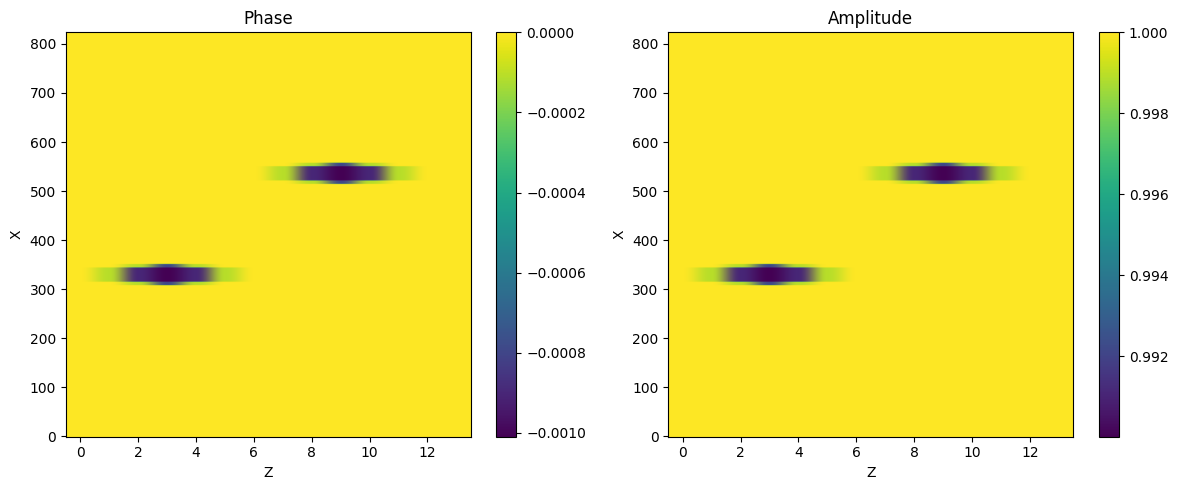

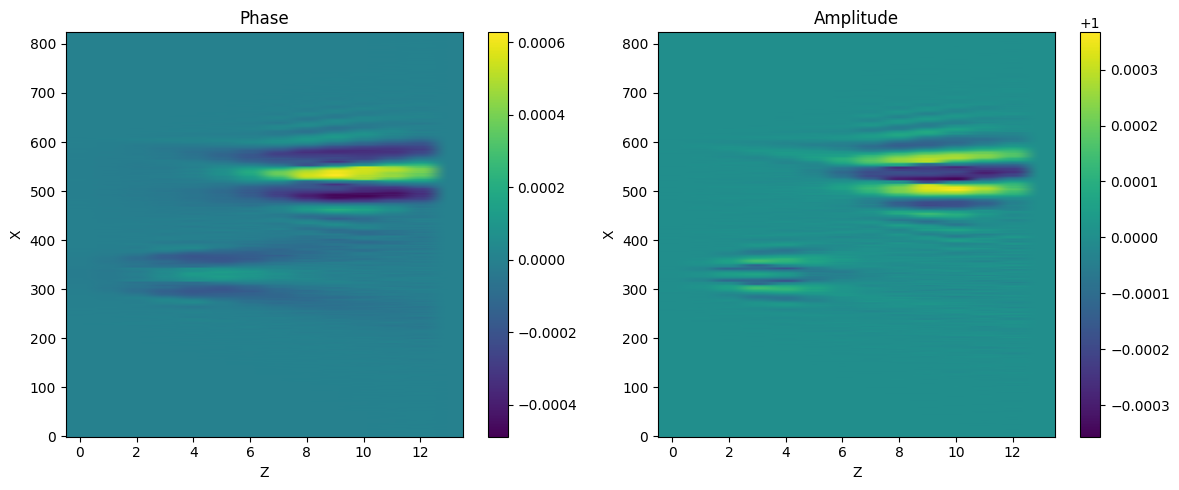

In [20]:
visualisation.plot_auto(sample_space.n_true, view="phase_amp", layout="single")

visualisation.plot_auto(n_est, view="phase_amp", layout="single")
